In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

import os
import random

In [2]:
def load_model(weights_path, config_path):
    model = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    layer_names = model.getLayerNames()
    try:
        layer_names = [layer_names[i-1] for i in model.getUnconnectedOutLayers()]
    except:
        layer_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]
    
    return model, layer_names

In [3]:
def get_bounding_boxes(model, layer_names, image, confidence_min=0.2, nms_threshold=0.3):
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    model.setInput(blob)
    layer_outputs = model.forward(layer_names)
    
    boxes = []
    confidences = []
    class_ids = []
    (H, W) = image.shape[:2]
    
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_min:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_min, nms_threshold)
    if len(idxs) > 0:
        idxs = idxs.flatten()
        boxes = [boxes[i] for i in idxs]
        confidences = [confidences[i] for i in idxs]
        class_ids = [class_ids[i] for i in idxs]
    
    return boxes, confidences, class_ids

In [4]:
def generate_random_gcps(img, num_samples, padding=(0, 0)):
    return np.random.randint(padding, 
                            high=(img.shape[0] - padding[0], img.shape[1] - padding[1]),
                            size=(num_samples, 2))

In [5]:
yolo_path = "../yolo"
yolov3, layer_names = load_model(f'{yolo_path}/yolov3-aerial.weights', f'{yolo_path}/yolov3.cfg')

/home/allanlago/anaconda3/envs/colab/lib/python3.8/site-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (177768889 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


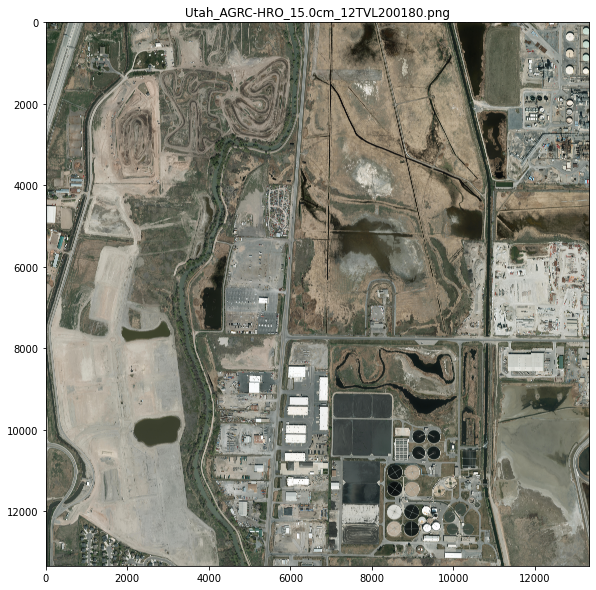

In [6]:
image_path = random.choice(os.listdir('../data'))
img = np.asarray(Image.open(f"../data/{image_path}").convert("RGB"))
plt.figure(figsize=(10, 10))
plt.title(image_path)
plt.imshow(img)

In [7]:
output_dim = (416, 416)
diag_len = np.ceil(np.sqrt(output_dim[0]**2 + output_dim[1]**2))
gcps = generate_random_gcps(img, 10, padding=(diag_len, diag_len))

In [8]:
def crop_around(img, centers, dim):
    x = centers.T[1] - dim[1] // 2
    y = centers.T[0] - dim[0] // 2
    return [img[p[0]:p[0]+dim[0], p[1]:p[1]+dim[1]] for p in zip(y, x)]

def center_crop(img, dim):
    return img[img.shape[0] // 2 - dim[0] // 2:img.shape[0] // 2 + dim[0] // 2,
               img.shape[1] // 2 - dim[1] // 2:img.shape[1] // 2 + dim[1] // 2]

In [9]:
def build_path(input_img, gcps, sample_dim, with_imgs=True):
    delta = np.diff(gcps, axis=0)
    directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
    angles = np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
    delta_angles = np.append(np.diff(angles), 0)

    sample_diag = np.floor(np.sqrt(sample_dim[0] ** 2 + sample_dim[1] ** 2)).astype("uint32")
    path = []

    if with_imgs:
        path_imgs = []
    
    for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
        steps = np.linalg.norm(t2 - t1) / 90  # segment_length / pixels_per_shot
        line = np.linspace(t1, t2, steps.astype('uint32'), dtype="uint32")
        path.extend([np.array([x, y, angle]) for (x, y) in line])

        if not with_imgs:
            continue

        # create image samples with appropriate rotation
        sample = crop_around(input_img, line, (sample_diag, sample_diag))
        rotated_sample = [center_crop(rotate(s, -angle, reshape=False), sample_dim) for s in sample]
        path_imgs.extend(rotated_sample)

        if delta_angle == 0:
            continue
    
        # end of segment, mock changing direction in place
        interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
        path.extend([np.array([line[-1][0], line[-1][1], theta]) for theta in interpolated_angles])
        path_imgs.extend([center_crop(rotate(sample[-1], -theta, reshape=False), sample_dim) for theta in interpolated_angles])
    
    return np.array(path), np.array(path_imgs)

In [10]:
trace, imgs = build_path(img, gcps, output_dim)

In [11]:
sequence_bbs = []

for cropped_img, center in zip(imgs[:30], trace[:, :2]):
    bbs, confs, class_id = get_bounding_boxes(yolov3, layer_names, cropped_img)
    
    if len(bbs) == 0:
        sequence_bbs.append((np.array([]), confs, class_id))
        continue

    bbs = np.array(bbs)
    bbs[:, :2] += center.astype(np.int64) - np.array(output_dim) // 2
    sequence_bbs.append((bbs, confs, class_id))


In [12]:
# for demonstration purposes only
labels_path = os.path.sep.join([yolo_path, "coco.names"])
LABELS = open(labels_path).read().strip().split("\n")

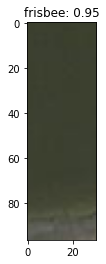

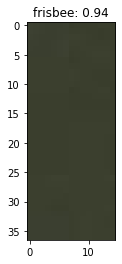

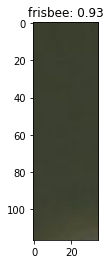

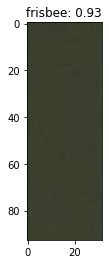

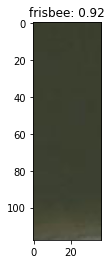

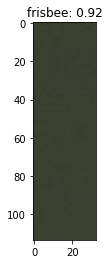

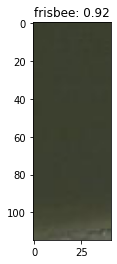

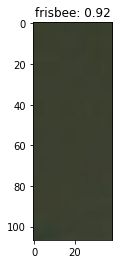

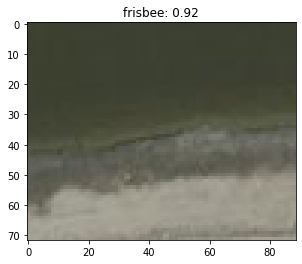

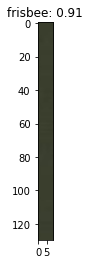

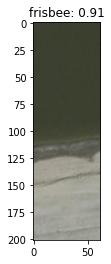

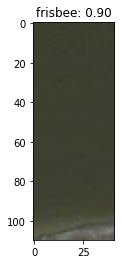

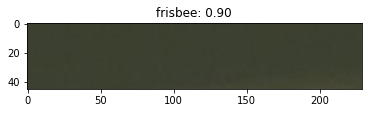

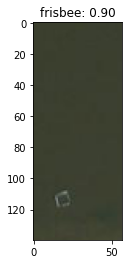

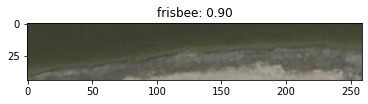

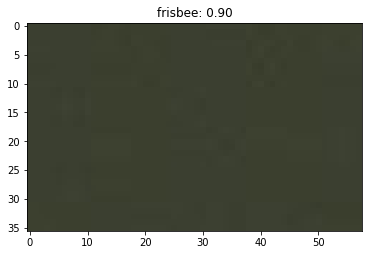

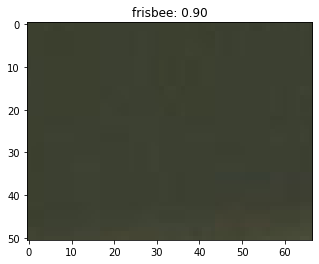

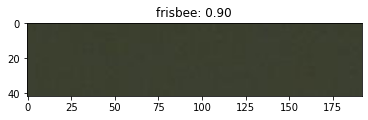

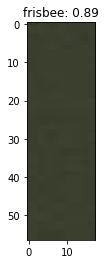

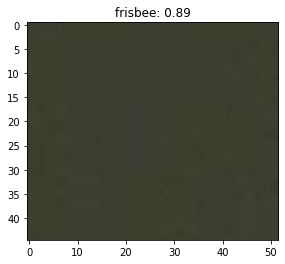

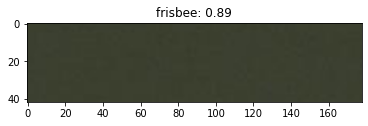

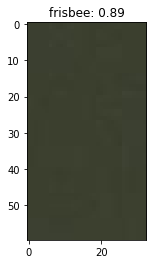

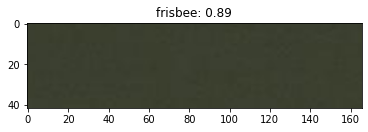

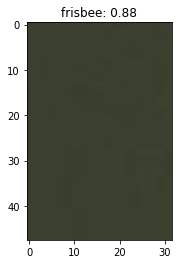

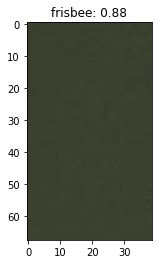

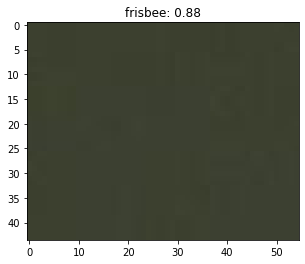

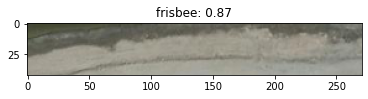

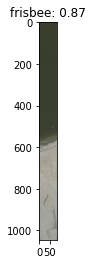

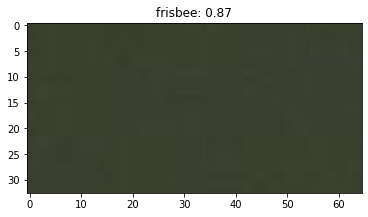

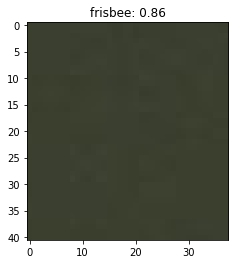

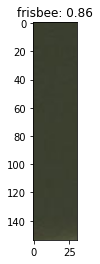

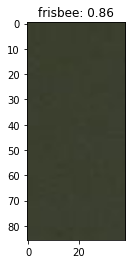

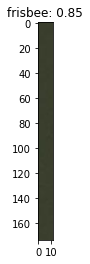

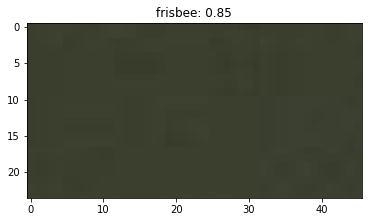

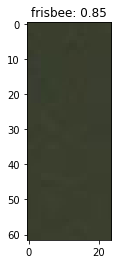

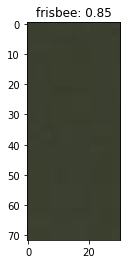

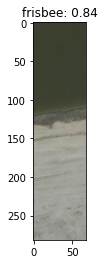

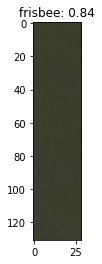

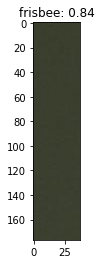

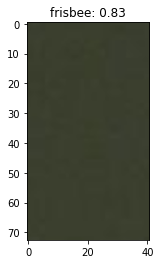

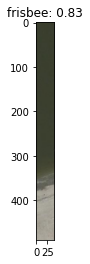

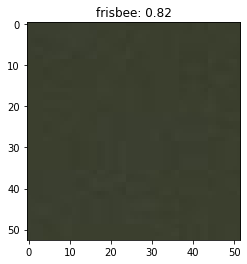

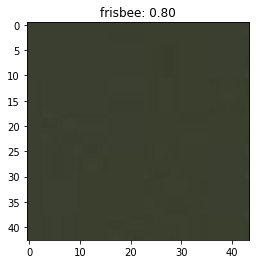

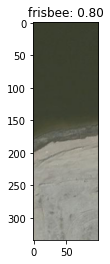

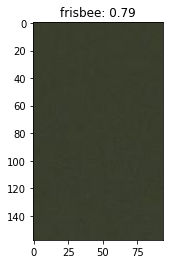

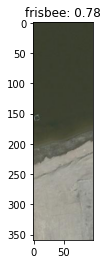

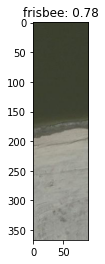

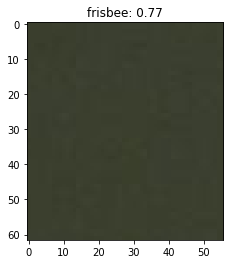

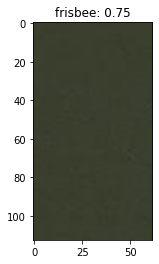

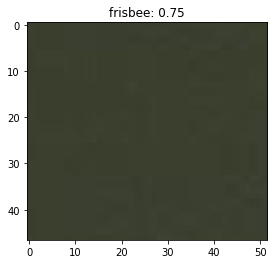

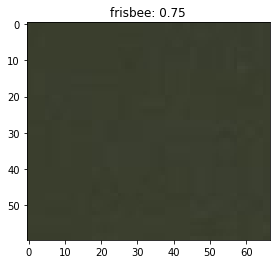

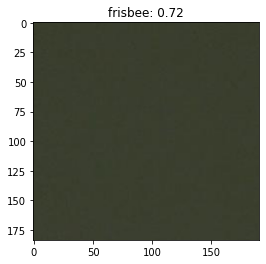

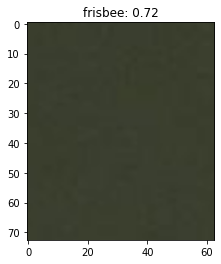

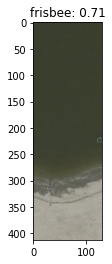

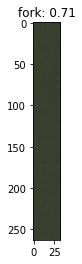

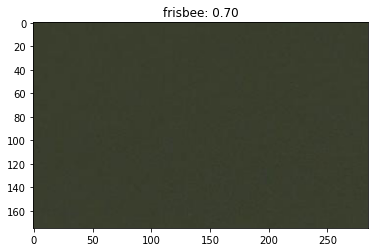

KeyboardInterrupt: 

In [13]:
for img_bb, confs, class_id in sequence_bbs:
    for (x, y, w, h), conf, c_id in zip(img_bb, confs, class_id):
        plt.imshow(img[x:x+w, y:y+h])
        plt.title(f"{LABELS[c_id]}: {conf:.2f}")
        plt.show()